In [116]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Task 2
#### Calculating Bias and Variance

## 2.2.1: Re-sampling the data

### Step 1
Loading and displaying the training data

In [117]:
with open('data/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('data/test.pkl', 'rb') as f2:
    test_data = pickle.load(f2)

In [118]:
table = pd.DataFrame(train_data)
table.columns = ["x", "y"]
table

x            y
0     39.182367  4765.404216
1     -7.088335  3782.003789
2    -39.801708   743.905279
3    -21.923343  5027.035592
4      4.096181 -4596.715255
...         ...          ...
7995  23.063270 -1486.452375
7996  29.566674   909.864473
7997  39.351459  2470.612264
7998  12.821086  1806.341001
7999 -28.092164   -77.523256

[8000 rows x 2 columns]

### Step 2
Dividing the training data into 10 equal parts randomly

In [119]:
np.random.shuffle(train_data) # so that splitting is random
train_data = np.array(np.split(train_data, 10))
# print(train_data)

Now every element train_data\[$i$\] is an array of $x$ values and $y = f(x)$ values.\
We can divide the array into separate `x_train` and `y_train` arrays such that $y\_train[i] = f(x\_train[i])$ \
Similarly, we can divide `test_data` into `x_test` and `y_test`

In [120]:
x_train, y_train = [], []
for i in range (0,10):
    x_train.append([[x] for x in train_data[i][:,0]]) # converting x values to 2D array
    y_train.append(train_data[i][:,1])

# print(x_train)
x_test = [[x] for x in test_data[:,0]]    # converting x values to 2D array
y_test = test_data[:,1]
# print(y_test)

## 2.2.2: Tabulate Bias and Variance

### Step 1
Train a linear classifier separately on the 10 training datasets.

In [121]:
classifier = [LinearRegression()]*10

Now we can train, predict, and plot graphs for all 10 datasets and compare with the $y$ values in the test data.

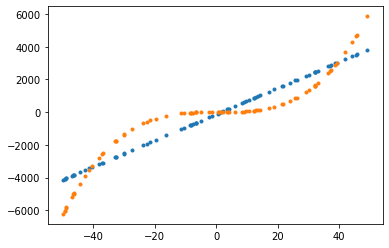

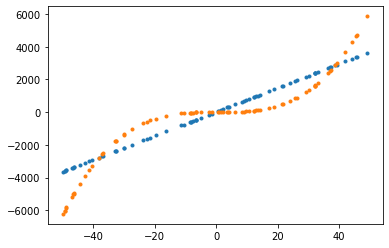

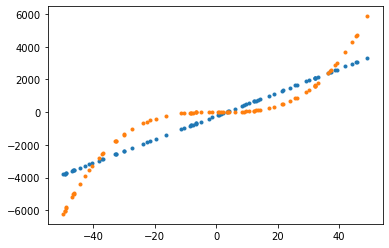

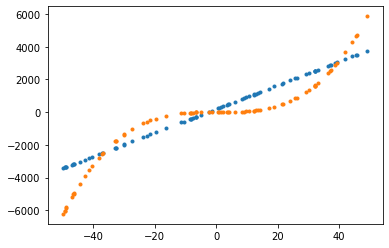

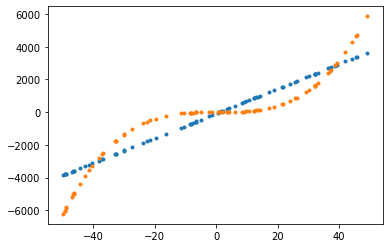

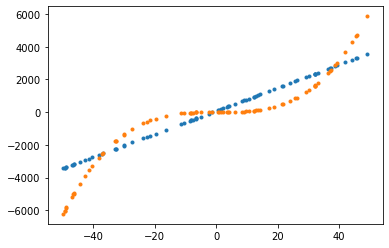

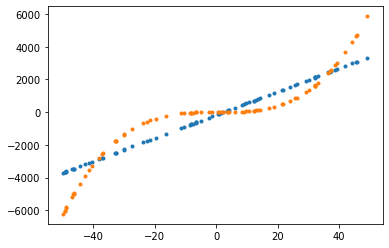

In [122]:
y_predict = []
for i in range (0,10):
    classifier[i].fit(x_train[i], y_train[i])
    y_predict.append(classifier[i].predict(x_test))
    plt.plot(x_test, y_predict[i], '.')
    plt.plot(x_test, y_test, '.')
    plt.show()

Here is the plot comparing the average predicted $y$ values with the test data values:

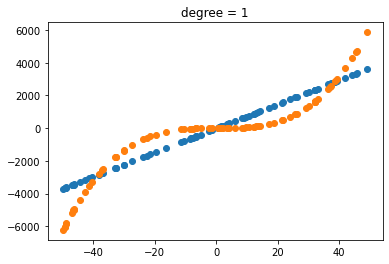

In [123]:
y_mean = np.mean(y_predict, axis=0)
plt.plot(x_test, y_mean, 'o')
plt.plot(x_test, y_test, 'o')
plt.title('degree = 1')
plt.show()

### Step 2
Calculate Bias$^2$ and Variance for the linear classifier

First define functions to calculate $bias^2$ and variance

In [124]:
def calc_bias2(y, y_mean):
    bias = np.array(y - y_mean)
    return np.mean(bias**2)

def calc_var(y_vec, y_mean):
    var = []
    for y in y_vec:
        var.append(np.mean((y - y_mean)**2))
    return np.mean(var)

and see the bias$^2$ and varaince of the predicted data

In [125]:
bias2 = calc_bias2(y_test, y_mean)
var = calc_var(y_predict, y_mean)
print(bias2, var)

1005328.280870083 37173.245059763794


### Step 3
Repeat this for polynomials till degree 20

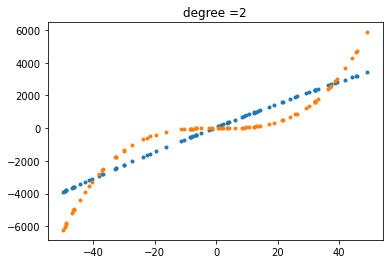

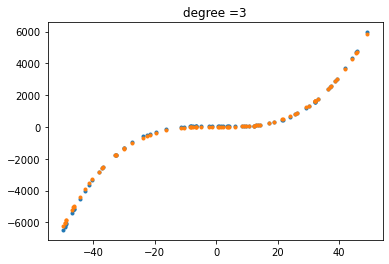

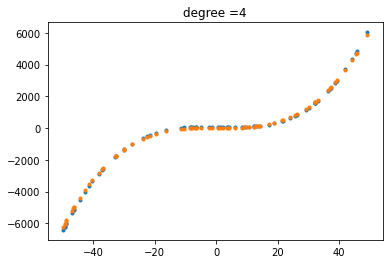

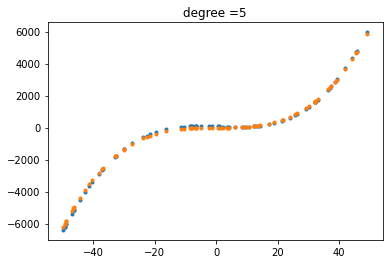

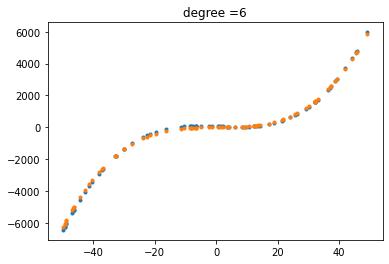

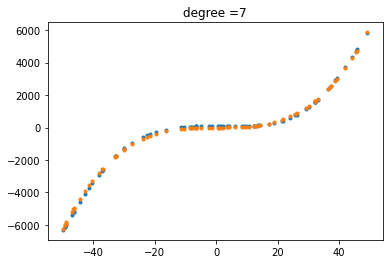

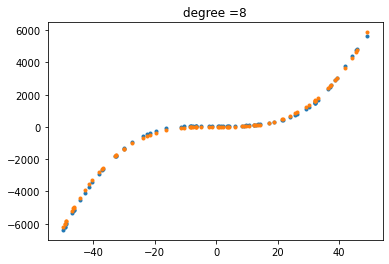

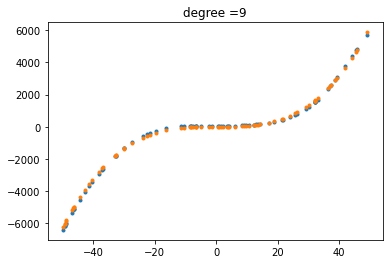

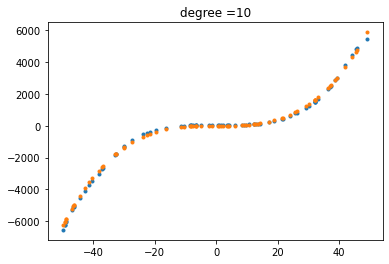

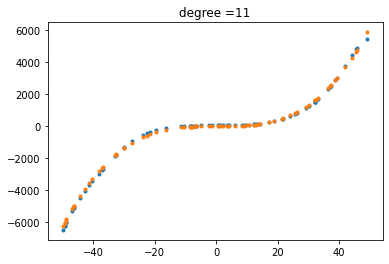

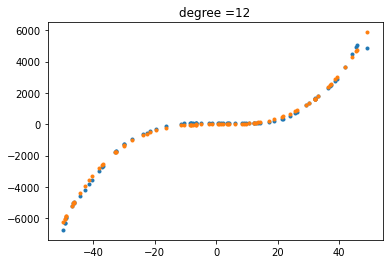

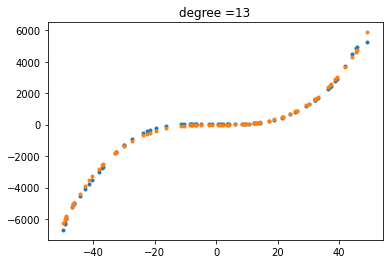

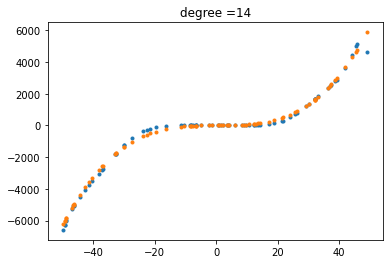

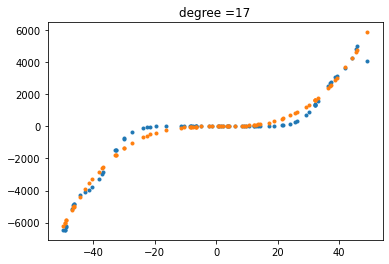

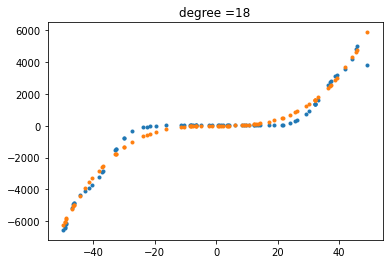

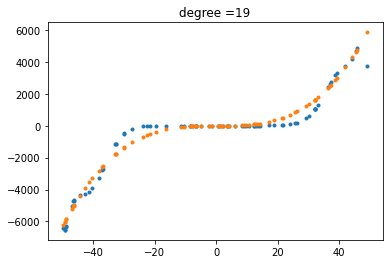

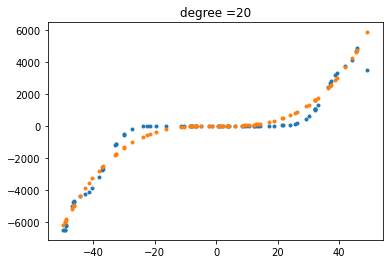

In [126]:
y_pred, y_m = [y_predict], [y_mean] # initialising the arrays with degree=1 values
# array index = deg - 1


for deg in range(2, 21):
    trans = [PolynomialFeatures(deg)]*10
    model = [LinearRegression()]*10
    y = []
    for i in range (0,10):
        x = trans[i].fit_transform(x_train[i])
        x_t = trans[i].transform(x_test)
        model[i].fit(x, y_train[i])
        y.append(model[i].predict(x_t))
    y_pred.append(y)
    y_m.append(np.mean(y, axis=0))
    plt.title('degree =' +str(deg))
    plt.plot(x_test, y_m[deg-1], '.')
    plt.plot(x_test, y_test, '.')
    plt.show()

Now we will store the bias$^2$ and variance values corresponding to each degree in arrays.

In [127]:
# initialise with bias^2 and variance of degree=1
bias_sq, variance = [bias2], [var]

for deg in range(2, 21):
    b2 = calc_bias2(y_test, y_m[deg-1])
    v = calc_var(y_pred[deg-1], y_m[deg-1])
    bias_sq.append(b2)
    variance.append(v)

### Step 4
Plot Bias$^2$ and Variance Values

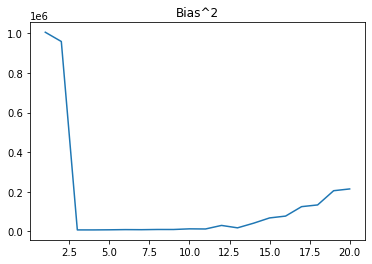

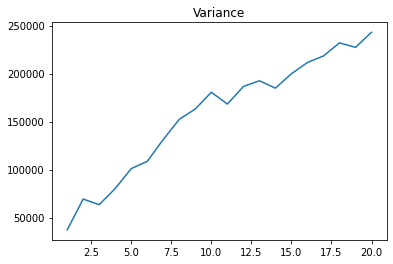

In [128]:
plt.plot(range(1, 21), bias_sq)
plt.title('Bias^2')
plt.show()
plt.plot(range(1, 21), variance)
plt.title('Variance')
plt.show()

### Step 5
Tabulate Bias and Variance Values

In [129]:
table = pd.DataFrame(np.array([np.sqrt(bias_sq), variance]).T)
table.columns = ['Bias', 'Variance']
table.index = range(1, 21)
table.round(3)

Bias    Variance
1   1002.661   37173.245
2    979.078   69319.908
3     86.220   63462.746
4     86.253   80287.961
5     89.465  101021.329
6     94.805  108603.073
7     92.533  131377.676
8     98.065  152350.901
9     97.762  163106.867
10   113.235  180559.221
11   110.210  168206.924
12   173.493  186520.081
13   133.867  192470.875
14   203.169  184828.770
15   260.652  199795.882
16   277.919  211528.176
17   353.437  218335.446
18   365.442  231959.356
19   453.138  227274.101
20   462.917  243011.578

# Task 3
#### Calculating Irreducible Error

$$σ^2 = E[(f(x) − f'(x))^2] − (Bias^2 + Variance)$$ \
where $f(x)$ represents the true value, $f'(x)$ represents the predicted value,
$E[(f(x)−f(x))^2]$ is the mean squared error and $σ^2$ represents irreducible error.

### Step 1
Calculating Mean Squared Error

In [130]:
def meansq_error(y, y_cap):
    err = np.array(y) - np.array(y_cap)
    return (np.mean(err**2))

Now, just like bias$^2$ and variance, store Mean Squared Error values corresponding to each degree in arrays.

In [131]:
mse = []
for deg in range(1, 21):
    mse.append(meansq_error(y_test, y_pred[deg-1]))
    
plt.plot(range(1, 21), mse)
plt.title('Mean Squared Error')
plt.show()

### Step 2
Calculating irreducible error ($\sigma^2$) using Bias$^2$, Variance and Mean Squared Error

In [132]:
sigma_2 = np.array(mse) - (np.array(bias_sq) + np.array(variance))

In [133]:
table = pd.DataFrame(sigma_2)
table.columns = ['Irreducible error']
table.index = range(1, 21)
table

Irreducible error
1        0.000000e+00
2        1.164153e-10
3        1.455192e-11
4        0.000000e+00
5        1.455192e-11
6        1.455192e-11
7        0.000000e+00
8        2.910383e-11
9        2.910383e-11
10       0.000000e+00
11       2.910383e-11
12       0.000000e+00
13       5.820766e-11
14       2.910383e-11
15      -5.820766e-11
16       0.000000e+00
17       0.000000e+00
18       0.000000e+00
19       0.000000e+00
20       5.820766e-11

# Task 4
#### Plotting Bias$^2$ - Variance Graph

In [134]:
plt.plot(range(1, 21), bias_sq, label='Bias^2')
plt.plot(range(1, 21), variance, label = 'Variance')
plt.plot(range(1, 21), mse, label= 'Error')
plt.xticks(range(1, 21, 2))
plt.grid(axis='x')
plt.legend()
plt.show()